In [1]:
import xarray as xr
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys

path = '/home/akazemi3/Desktop/MB_Lab_Project/'
sys.path.append(path)
from analysis.neural_data_regression.tools.regression import *

from tools.processing import *
from tools.loading import *

import pandas as pd
import seaborn as sns

ROOT_PATH = '/data/atlas/model_scores'
BEST_ALPHA_PATH = '/data/atlas/regression_alphas'    
RESULTS_PATH = '' 

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [16]:
def results_best_alpha(model_dict, dataset, regions, mode):

    df = pd.DataFrame()
    index = 0
 

    for model_name, model_info in model_dict.items():

    
        corr = 0
        for region in regions:     
       
            if model_info["alpha_file_name"] == None:
                alpha=0
            else:
                file = open(os.path.join(BEST_ALPHA_PATH,f'{model_info["alpha_file_name"]}_{dataset}_{region}'),'rb')
                best_alphas = pickle.load(file)
                alpha = best_alphas[model_name]
            regression_model = Ridge(alpha=alpha)

            identifier = model_name + '_'  + dataset + '_' + region + '_' + mode + '_' + f'Ridge(alpha={alpha})' 

            data = xr.open_dataset(os.path.join(ROOT_PATH,f'{identifier}'))
            corr += np.mean(data.r_value.values)
            
        mean_corr = corr/len(regions)
        df_tmp =  pd.DataFrame({'mean_score':mean_corr,
                                'model':model_info['name'],
                                'features':model_info['features'],
                               'alpha':alpha},index=[index])    

        df = pd.concat([df,df_tmp])
        index += 1    

    return df



def plot_best_alpha(df,df_alexnet,df_alexnet_u,file_name,dataset,leg=False):
        
    
    fig = plt.figure(figsize=(3.7,3),dpi=200)
    sns.axes_style()
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    plt.xscale('log')
    sns.lineplot(x=df.features,y=df.mean_score,hue=df.model,marker='o')
    
    plt.axhline(y=df_alexnet.mean_score.values, color='green', linestyle='--',label='AlexNet')
    plt.axhline(y=df_alexnet_u.mean_score.values, color='orange', linestyle='--',label='AlexNet Untrained')
        

    
    plt.xlabel(xlabel='')
    
    plt.ylabel(ylabel='')        
    if dataset == 'majajhong':
        plt.ylim([0.1,0.6])
    elif dataset == 'naturalscenes_zscored_processed':
        plt.ylim([0.1,df.mean_score.max() + 0.05])
    
    plt.rc('xtick', labelsize=12) 
    plt.rc('ytick', labelsize=12) 
    
    
    
    plt.legend()
    if leg== True:
        plt.legend()
    else:
        plt.legend('', frameon=False)

    if file_name is not None:
        plt.savefig(os.path.join(RESULTS_PATH,f'{file_name}.png'))
    
    

In [8]:
def plotByRegion(regions,dataset,mode='test',file_name=None):
        
    
    name = '3 Layer Model'
    alpha_file_name = 'model_3L_mp'
    model_dict = {
            f'model_3L_mp_100':{'name':name,'features':100,'alpha_file_name':alpha_file_name},
            f'model_3L_mp_1000':{'name':name,'features':1000,'alpha_file_name':alpha_file_name},
            f'model_3L_mp_10000':{'name':name,'features':10000,'alpha_file_name':alpha_file_name},
            f'model_3L_mp_100000':{'name':name,'features':100000,'alpha_file_name':alpha_file_name},
    }
    df_model_3L = results_best_alpha(model_dict, dataset, regions, mode)
    
    
    
    name = 'Alexnet Untrained'
    alpha_file_name = 'alexnet_untrained_mp'
    model_dict = {
            f'alexnet_untrained_mp':{'name':name,'features':0,'alpha_file_name':alpha_file_name},
    }
    df_alexnet_u = results_best_alpha(model_dict, dataset, regions, mode)

    
    name = 'Alexnet'
    alpha_file_name = 'alexnet_mp'
    model_dict = {
            f'alexnet_mp':{'name':name,'features':0,'alpha_file_name':alpha_file_name},
    }
    df_alexnet = results_best_alpha(model_dict, dataset, regions, mode)

    
    plot_best_alpha(df_model_3L,
                    df_alexnet,
                    df_alexnet_u,file_name=file_name,dataset=dataset)


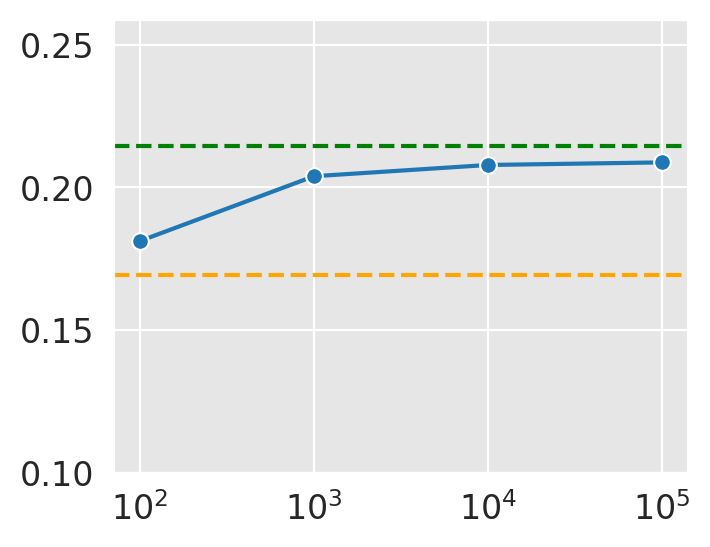

In [17]:
regions=['V4']
dataset = 'naturalscenes_zscored_processed'
file_name = f'{regions}_{dataset}'
plotByRegion(regions,dataset,file_name=file_name)

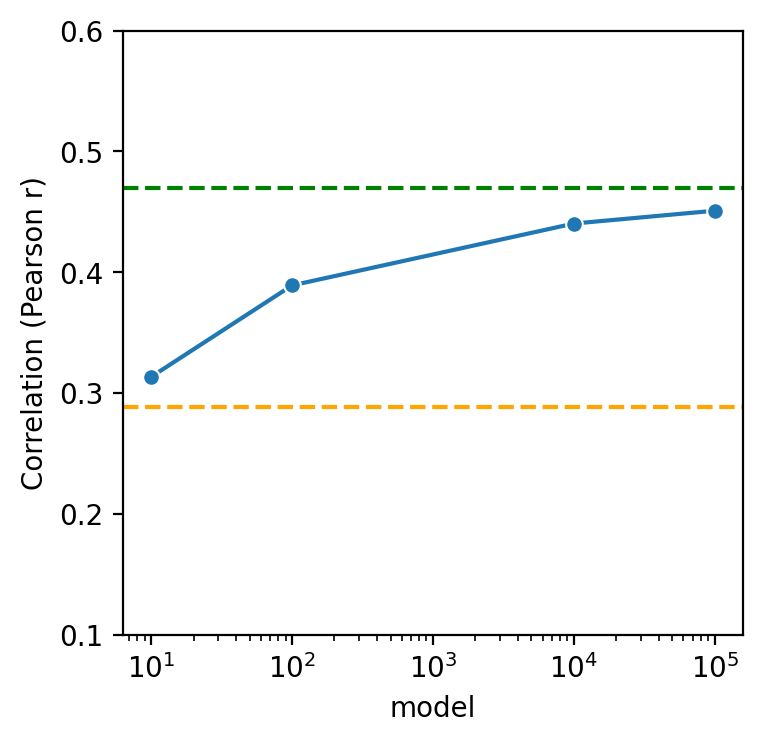

In [17]:
regions=['IT']
dataset = 'majajhong'
file_name = f'{regions}_{dataset}'
plotByRegion(regions,dataset,file_name=file_name)

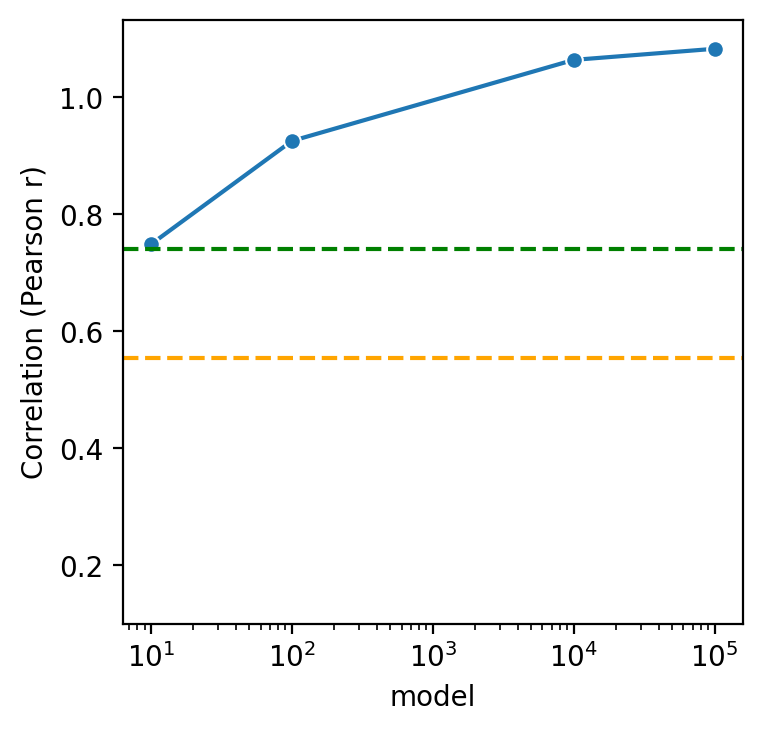

In [ ]:
plotByRegion(['V4'],dataset='majajhong',file_name='majajhong_results_V4')

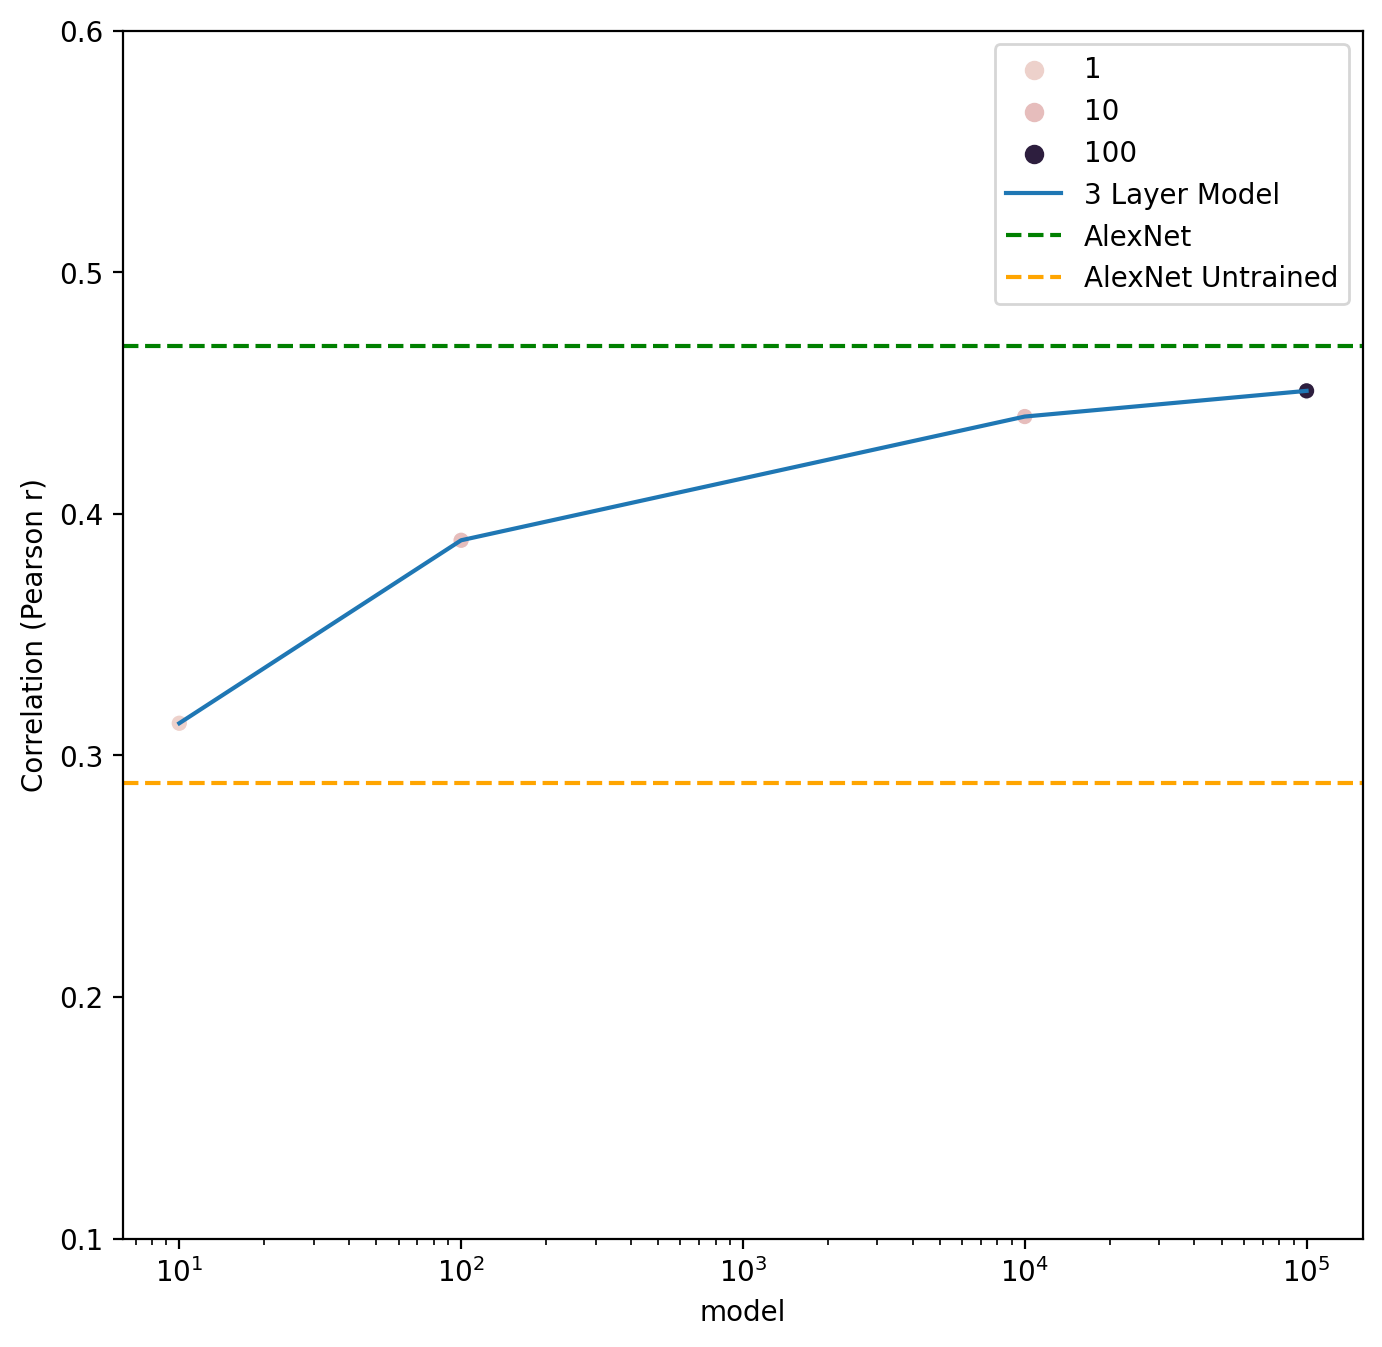

In [15]:
plotByRegion(['IT'],dataset='majajhong',file_name='majahong_results_IT')

,mean_score,model,features,alpha
0,0.313286,3 Layer Model,10,1
1,0.389016,3 Layer Model,100,10
2,0.440230,3 Layer Model,10000,10


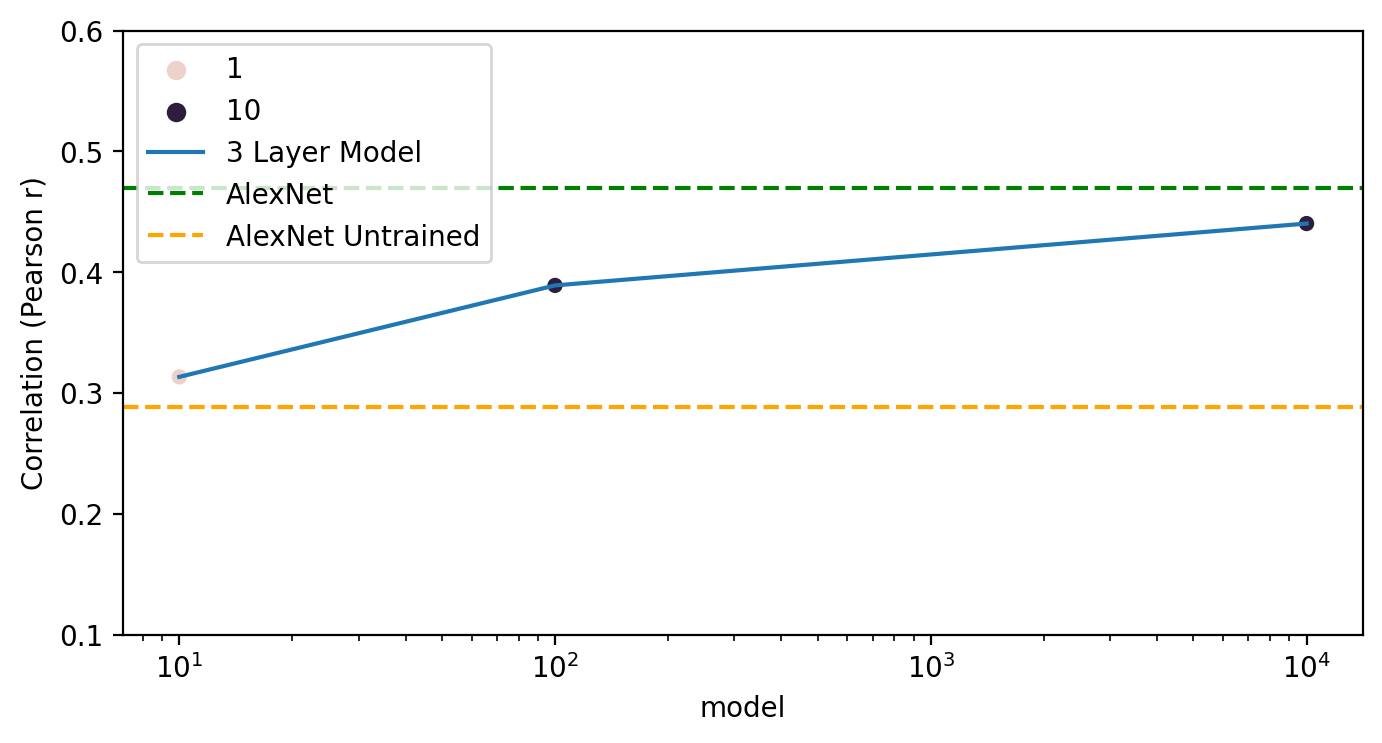

In [35]:
plotByRegion(['IT'],dataset='majajhong',file_name='majahong_results_IT')

In [ ]:
def results_best_alpha_cnn_layerwise(models, dataset,regions, layers):

    
    root_path = '/data/atlas/model_scores'
    df_max_alphas = pd.read_csv(f'/home/akazemi3/Desktop/MB_Lab_Project/analysis/neural_data_regression/max_alphas_cnns_{dataset}_mp_layerwise.csv')
    dict_max_alphas = df_max_alphas.set_index(['region','model']).to_dict()['alpha']

    
    df = pd.DataFrame()
    index = 0
    
        
    for model in models:
        for region in regions:

                

            for layer in layers:
                alpha = dict_max_alphas[(region, f'{model}_{layer}')]
                regression_model = f'Ridge(alpha={alpha})'

                identifier = model + '_' + dataset + '_' + layer + '_' + region + '_' + regression_model


                data = xr.open_dataset(os.path.join(root_path,f'{identifier}'))
                r_values = data.where(data.region == region,drop=True).r_value.values
                mean_r = np.mean(r_values)
                df_tmp =  pd.DataFrame({'mean_score':mean_r,
                                        'alpha':alpha,
                                        'model':f'{model}_{layer}',
                                        'region':region},index=[index])    

                df = pd.concat([df,df_tmp])
                index += 1    
    
    return df

def plot_best_alpha_layerwise(df,file_name,dataset):
        
    
    fig = plt.figure(figsize=(8,4),dpi=200)
    

    sns.scatterplot(x=df.region,y=df.mean_score,hue=df.model)
    
    plt.ylabel(ylabel='Correlation (Pearson r)')        
    
    plt.savefig(f'/home/akazemi3/Desktop/MB_Lab_Project/results/parameter_study/{file_name}_{dataset}.png')

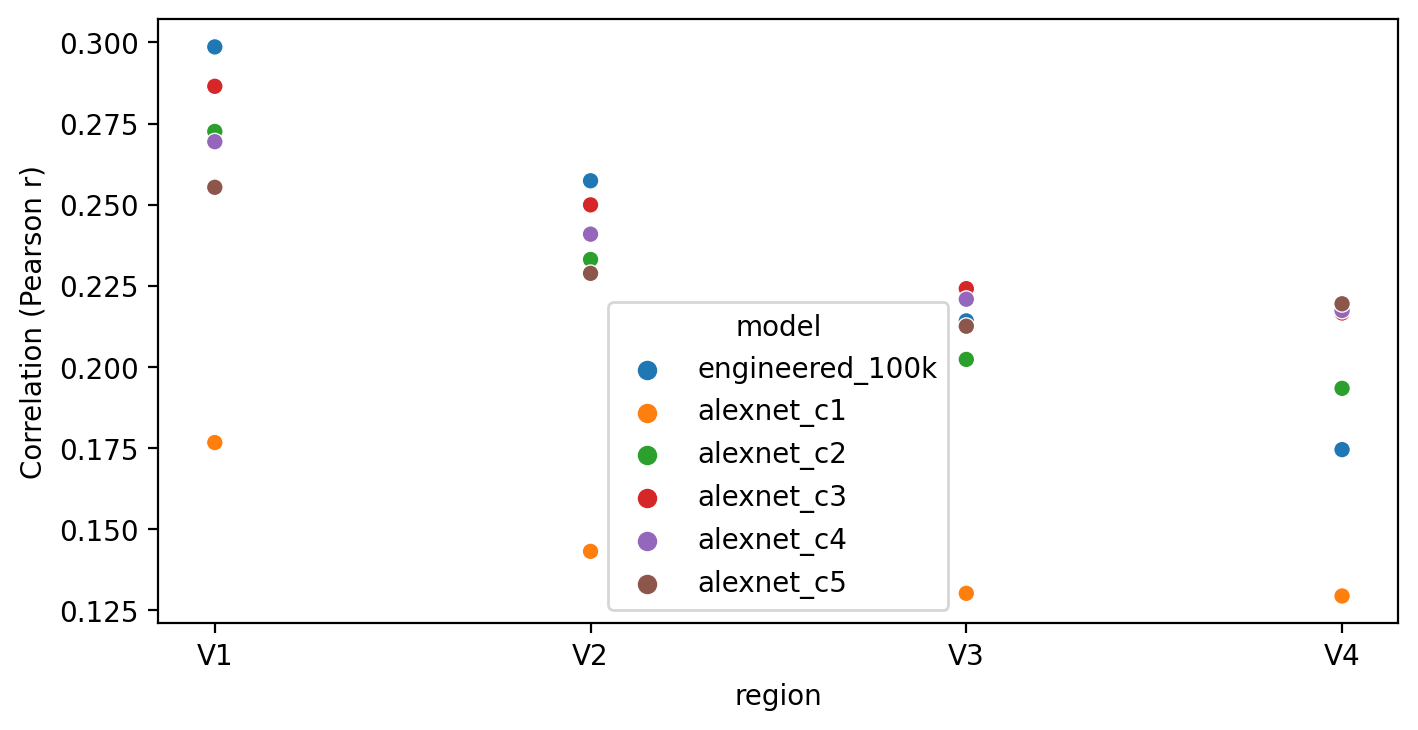

In [100]:
dataset = 'naturalscenes_zscored_processed'
regions = ['V1','V2','V3','V4']


models = f'model_final_mp'
features_range = (5,5)
df_model = results_best_alpha(models, features_range, dataset,regions)


cnn_models = ['alexnet_mp']
df_cnn = results_best_alpha_cnn_layerwise(cnn_models,dataset,regions,layers)

df = pd.concat([df_model,df_cnn])
df.model = df.model.map({'model_final_mp_100000':'engineered_100k',
                             'alexnet_mp_features.2':'alexnet_c1',
                               'alexnet_mp_features.5':'alexnet_c2',
                               'alexnet_mp_features.7':'alexnet_c3',
                               'alexnet_mp_features.9':'alexnet_c4',
                               'alexnet_mp_features.12':'alexnet_c5'})

file_name = f'best_alpha_all_models_naturalscenes_layerwise'
plot_best_alpha_layerwise(df,file_name,dataset)

In [2]:
import torch
w_l = []
f = torch.rand(4,1,3,3)
for i in range(3):
    w_l.append(f)
weight = torch.concat(w_l,dim=1)